# TP1 - Regresión
Notebook inicial para el trabajo práctico.

In [1]:
# 1. Importación de librerías necesarias
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import holidays

In [2]:
# 2. Carga de datos. Se carga el dataset que contiene los viajes de taxi.
file_path= 'uber_fares.csv'
df = pd.read_csv(file_path)

# visualizacion de algunos datos
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

In [3]:
# Se realiza un análisis inicial para comprender el comportamiento de cada variable.
df.info(), df.apply(pd.unique), df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


(None,
 key                  [24238194, 27835199, 44984355, 25894730, 17610...
 date                 [2015-05-07 19:52:06.0000003, 2009-07-17 20:04...
 fare_amount          [7.5, 7.7, 12.9, 5.3, 16.0, 4.9, 24.5, 2.5, 9....
 pickup_datetime      [2015-05-07 19:52:06 UTC, 2009-07-17 20:04:56 ...
 pickup_longitude     [-73.99981689453125, -73.994355, -74.005043, -...
 pickup_latitude      [40.73835372924805, 40.728225, 40.74077, 40.79...
 dropoff_longitude    [-73.99951171875, -73.99471, -73.962565, -73.9...
 dropoff_latitude     [40.72321701049805, 40.750325, 40.772647, 40.8...
 passenger_count                             [1, 3, 5, 2, 4, 6, 0, 208]
 dtype: object,
 key                  200000
 date                 200000
 fare_amount            1244
 pickup_datetime      196629
 pickup_longitude      71066
 pickup_latitude       83835
 dropoff_longitude     76894
 dropoff_latitude      90585
 passenger_count           8
 dtype: int64)

In [4]:
# Eliminar la columna 'key' porque no aporta al análisis
df = df.drop(columns=['key'])

In [5]:
df['pickup_datetime'].isna().sum()

np.int64(0)

In [6]:
# Análisis de redundancia entre 'date' y 'pickup_datetime'
print("Comparación entre las columnas 'date' y 'pickup_datetime':")
print("\nPrimeras 5 filas de ambas columnas:")
if 'date' in df.columns:
    print(df[['date', 'pickup_datetime']].head())
    
    # Verificar si la fecha extraída de pickup_datetime coincide con date
    df['fecha_extraida'] = pd.to_datetime(df['pickup_datetime']).dt.date
    df['date_convertida'] = pd.to_datetime(df['date']).dt.date if 'date' in df.columns else None
    
    print(f"\n¿Las fechas coinciden? {(df['fecha_extraida'] == df['date_convertida']).all()}")
    print(f"Número de coincidencias: {(df['fecha_extraida'] == df['date_convertida']).sum()}")
    print(f"Total de registros: {len(df)}")
    
    # Limpiar columnas temporales
    df = df.drop(columns=['fecha_extraida', 'date_convertida'])
else:
    print("La columna 'date' ya fue eliminada.")
    print("pickup_datetime contiene tanto la fecha como la hora:")
    print(df[['pickup_datetime']].head())
    print(f"\nTipo de datos: {df['pickup_datetime'].dtype}")
    print(f"Ejemplo de información temporal extraíble:")
    print(f"- Fecha: {pd.to_datetime(df['pickup_datetime']).dt.date.iloc[0]}")
    print(f"- Hora: {pd.to_datetime(df['pickup_datetime']).dt.time.iloc[0]}")
    print(f"- Año: {pd.to_datetime(df['pickup_datetime']).dt.year.iloc[0]}")
    print(f"- Mes: {pd.to_datetime(df['pickup_datetime']).dt.month.iloc[0]}")
    print(f"- Día: {pd.to_datetime(df['pickup_datetime']).dt.day.iloc[0]}")

Comparación entre las columnas 'date' y 'pickup_datetime':

Primeras 5 filas de ambas columnas:
                            date          pickup_datetime
0    2015-05-07 19:52:06.0000003  2015-05-07 19:52:06 UTC
1    2009-07-17 20:04:56.0000002  2009-07-17 20:04:56 UTC
2   2009-08-24 21:45:00.00000061  2009-08-24 21:45:00 UTC
3    2009-06-26 08:22:21.0000001  2009-06-26 08:22:21 UTC
4  2014-08-28 17:47:00.000000188  2014-08-28 17:47:00 UTC

¿Las fechas coinciden? True
Número de coincidencias: 200000
Total de registros: 200000


In [7]:
# Eliminar la columna 'date' porque es completamente redundante con 'pickup_datetime'
# Ambas columnas contienen exactamente la misma información temporal
# pickup_datetime ya nos proporciona fecha y hora completa
df = df.drop(columns=['date'])

Para lograr determinar si un fare amount grande es un outlier necesitamos calcular la variable distancia para lograr comprender si se corresponden los valores o no. Luego de una evaluación de la mejor función de distancia, llegamos a la conclusión que la manhattan se ajusta mejor a la estructura de la ciudad en estudio.

In [8]:

# Haversine
# Distancia haversine (en km)
def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en km
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

df['dist_haversine'] = haversine(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude'])

In [9]:
# Verificar si hay valores NaN en fare__amount
df['fare_amount'].isna().sum()

np.int64(0)

Columnas disponibles en el dataframe:
['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'dist_haversine']
Shape del dataframe: (200000, 8)


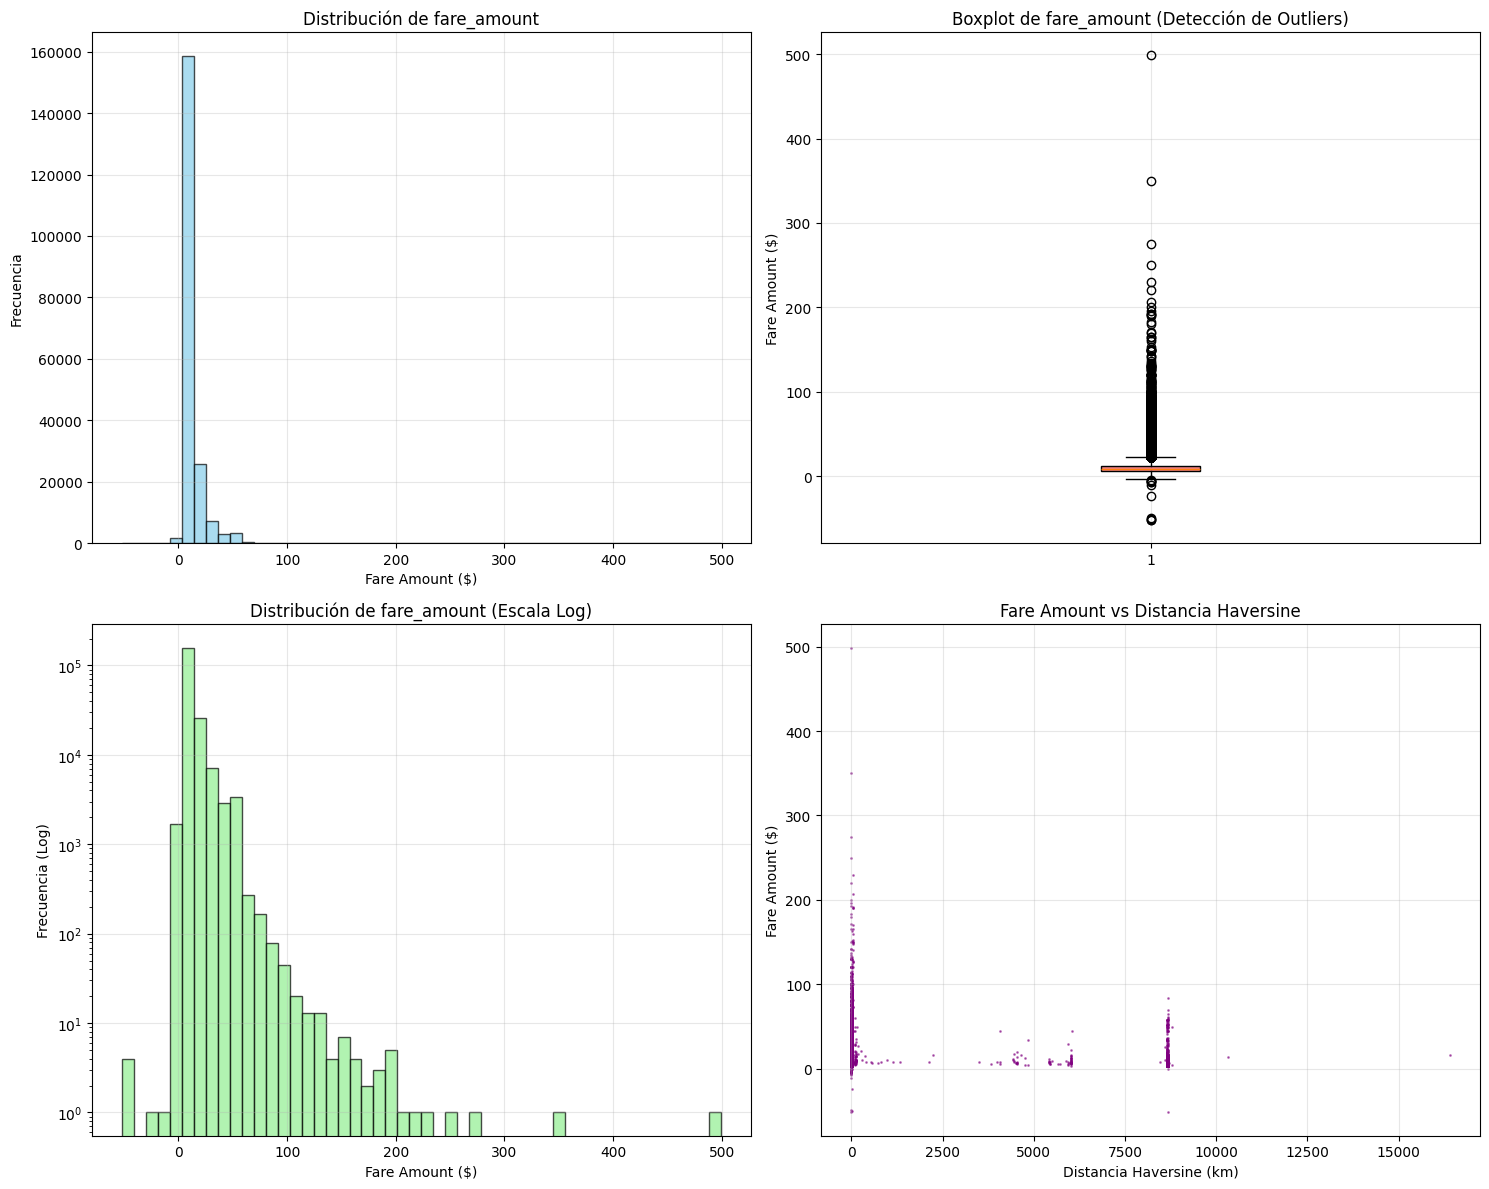


ESTADÍSTICAS DESCRIPTIVAS DE FARE_AMOUNT
count    200000.000000
mean         11.359955
std           9.901776
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

Rango de valores:
Mínimo: $-52.00
Máximo: $499.00
Rango: $551.00

ANÁLISIS DE OUTLIERS (Método IQR)
Q1 (25%): $6.00
Q3 (75%): $12.50
IQR: $6.50
Límite inferior: $-3.75
Límite superior: $22.25
Cantidad de outliers: 17,167 (8.58% del total)

VALORES EXTREMOS
Los 10 valores más altos de fare_amount:
        fare_amount  dist_haversine
170081       499.00        0.000790
4292         350.00        0.000000
185325       275.00        0.000000
71715        250.00        0.000000
197493       230.00       37.989067
29261        220.00        2.914493
23682        206.38       60.100889
196647       200.00        0.000000
184901       196.00        0.001259
33911        192.33        0.000000

Los 10 valores más bajos de fare_amount:
   

In [10]:
# Análisis de distribución de fare_amount y detección de outliers
print("Columnas disponibles en el dataframe:")
print(df.columns.tolist())
print(f"Shape del dataframe: {df.shape}")

# Verificar si la columna dist_haversine existe
has_distance = 'dist_haversine' in df.columns

if has_distance:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
else:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histograma para ver la distribución general
axes[0, 0].hist(df['fare_amount'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribución de fare_amount')
axes[0, 0].set_xlabel('Fare Amount ($)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# 2. Boxplot para identificar outliers
box = axes[0, 1].boxplot(df['fare_amount'], patch_artist=True)
box['boxes'][0].set_facecolor('lightcoral')
axes[0, 1].set_title('Boxplot de fare_amount (Detección de Outliers)')
axes[0, 1].set_ylabel('Fare Amount ($)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Histograma con escala logarítmica para mejor visualización
axes[1, 0].hist(df['fare_amount'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('Distribución de fare_amount (Escala Log)')
axes[1, 0].set_xlabel('Fare Amount ($)')
axes[1, 0].set_ylabel('Frecuencia (Log)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Condicional: si existe dist_haversine, hacer scatter plot, sino histograma acumulativo
if has_distance:
    axes[1, 1].scatter(df['dist_haversine'], df['fare_amount'], alpha=0.5, s=1, color='purple')
    axes[1, 1].set_title('Fare Amount vs Distancia Haversine')
    axes[1, 1].set_xlabel('Distancia Haversine (km)')
    axes[1, 1].set_ylabel('Fare Amount ($)')
else:
    # Histograma acumulativo como alternativa
    axes[1, 1].hist(df['fare_amount'], bins=50, cumulative=True, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].set_title('Distribución Acumulativa de fare_amount')
    axes[1, 1].set_xlabel('Fare Amount ($)')
    axes[1, 1].set_ylabel('Frecuencia Acumulativa')

axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas descriptivas de fare_amount
print("\n" + "="*60)
print("ESTADÍSTICAS DESCRIPTIVAS DE FARE_AMOUNT")
print("="*60)
print(df['fare_amount'].describe())

print(f"\nRango de valores:")
print(f"Mínimo: ${df['fare_amount'].min():.2f}")
print(f"Máximo: ${df['fare_amount'].max():.2f}")
print(f"Rango: ${df['fare_amount'].max() - df['fare_amount'].min():.2f}")

# Identificación de outliers usando IQR
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['fare_amount'] < lower_bound) | (df['fare_amount'] > upper_bound)]

print(f"\n" + "="*60)
print("ANÁLISIS DE OUTLIERS (Método IQR)")
print("="*60)
print(f"Q1 (25%): ${Q1:.2f}")
print(f"Q3 (75%): ${Q3:.2f}")
print(f"IQR: ${IQR:.2f}")
print(f"Límite inferior: ${lower_bound:.2f}")
print(f"Límite superior: ${upper_bound:.2f}")
print(f"Cantidad de outliers: {len(outliers):,} ({len(outliers)/len(df)*100:.2f}% del total)")

# Mostrar algunos outliers extremos
print(f"\n" + "="*60)
print("VALORES EXTREMOS")
print("="*60)
print(f"Los 10 valores más altos de fare_amount:")
if has_distance:
    print(df.nlargest(10, 'fare_amount')[['fare_amount', 'dist_haversine']].to_string())
else:
    print(df.nlargest(10, 'fare_amount')[['fare_amount']].to_string())

print(f"\nLos 10 valores más bajos de fare_amount:")
if has_distance:
    print(df.nsmallest(10, 'fare_amount')[['fare_amount', 'dist_haversine']].to_string())
else:
    print(df.nsmallest(10, 'fare_amount')[['fare_amount']].to_string())

# Análisis adicional de percentiles
print(f"\n" + "="*60)
print("ANÁLISIS DE PERCENTILES")
print("="*60)
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = df['fare_amount'].quantile(p/100)
    print(f"Percentil {p:2d}%: ${value:6.2f}")

# Análisis de distribución
print(f"\n" + "="*60)
print("ANÁLISIS DE DISTRIBUCIÓN")
print("="*60)
mean_val = df['fare_amount'].mean()
median_val = df['fare_amount'].median()
std_val = df['fare_amount'].std()

print(f"Media: ${mean_val:.2f}")
print(f"Mediana: ${median_val:.2f}")
print(f"Desviación estándar: ${std_val:.2f}")
print(f"Coeficiente de variación: {(std_val/mean_val)*100:.2f}%")

# Asimetría de la distribución
skewness = df['fare_amount'].skew()
print(f"Asimetría (skewness): {skewness:.2f}")
if skewness > 1:
    print("  → Distribución muy asimétrica hacia la derecha")
elif skewness > 0.5:
    print("  → Distribución moderadamente asimétrica hacia la derecha")
elif skewness > -0.5:
    print("  → Distribución aproximadamente simétrica")
elif skewness > -1:
    print("  → Distribución moderadamente asimétrica hacia la izquierda")
else:
    print("  → Distribución muy asimétrica hacia la izquierda")

In [11]:
df['fare_amount'].value_counts().sort_index().tail(20)

fare_amount
163.00    1
165.00    1
165.33    1
170.00    1
171.35    1
180.00    1
183.00    1
190.00    1
190.83    1
191.80    1
192.33    1
196.00    1
200.00    1
206.38    1
220.00    1
230.00    1
250.00    1
275.00    1
350.00    1
499.00    1
Name: count, dtype: int64

In [12]:
df.nlargest(20, 'fare_amount')[['fare_amount', 'dist_haversine']]

,fare_amount,dist_haversine
170081,499.00,0.000790
4292,350.00,0.000000
185325,275.00,0.000000
71715,250.00,0.000000
197493,230.00,37.989067
29261,220.00,2.914493
23682,206.38,60.100889
196647,200.00,0.000000
184901,196.00,0.001259
33911,192.33,0.000000


In [13]:
df.sort_values('fare_amount', ascending=False)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_haversine
170081,499.00,2011-04-10 04:10:00 UTC,-73.968377,40.764602,-73.968368,40.764600,1,0.000790
4292,350.00,2014-10-24 20:20:00 UTC,0.000000,0.000000,0.000000,0.000000,3,0.000000
185325,275.00,2013-04-19 00:00:00 UTC,0.000000,0.000000,0.000000,0.000000,1,0.000000
71715,250.00,2013-05-11 00:31:00 UTC,0.000000,0.000000,0.000000,0.000000,1,0.000000
197493,230.00,2014-09-07 08:39:00 UTC,-73.937765,40.758267,-74.382200,40.700890,2,37.989067
...,...,...,...,...,...,...,...,...
92063,-23.70,2010-03-12 08:49:10 UTC,-73.952740,40.768233,-74.007028,40.707338,3,8.171296
89322,-49.57,2010-03-09 08:26:10 UTC,-73.972772,40.785657,-73.972867,40.785500,5,0.019203
164056,-50.50,2010-03-16 15:27:10 UTC,-73.784868,40.648677,-73.976975,40.763522,3,20.622782
111589,-52.00,2015-02-23 19:26:44 UTC,-73.984665,40.759026,0.000000,0.000000,5,8666.246939


In [14]:
# Resetear los índices del DataFrame después de los filtrados
df = df.reset_index(drop=True)
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_haversine
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683323
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457590
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.036377
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.661683
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,4.475450
...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1,0.112210
199996,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1,1.875050
199997,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2,12.850319
199998,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1,3.539715


In [15]:
# Crear objeto de feriados de New York
feriados = holidays.US(state='NY')

# Si pickup_datetime es string, primero conviértelo a datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Crear la variable dummy: 1 si es feriado, 0 si no
df['es_feriado'] = df['pickup_datetime'].dt.date.apply(lambda x: 1 if x in feriados else 0)

# Crear variable dummy: 1 si es fin de semana (sábado o domingo), 0 si es día de semana (lunes a viernes)
df['es_fin_de_semana'] = df['pickup_datetime'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

# Crear variable: 1 si es fin de semana o feriado, 0 si es día de semana y no feriado
df['es_no_laborable'] = ((df['es_fin_de_semana'] == 1) | (df['es_feriado'] == 1)).astype(int)

# Dropear columnas auxiliares
df = df.drop(columns=['es_feriado', 'es_fin_de_semana'])

df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_haversine,es_no_laborable
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,0
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,0
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,0
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,0
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,0
...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,0.112210,1
199996,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,1.875050,0
199997,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,12.850319,0
199998,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,3.539715,0


In [16]:
# Crear variable 'hora_del_dia' (0 a 23) a partir de pickup_datetime
df['hora_del_dia'] = df['pickup_datetime'].dt.hour
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_haversine,es_no_laborable,hora_del_dia
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,0,19
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,0,20
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,0,21
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,0,8
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,0,17


In [17]:
# Crear variables dummies según el día del mes de pickup_datetime
df['1era_mitad_mes'] = (df['pickup_datetime'].dt.day < 15).astype(int)
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_haversine,es_no_laborable,hora_del_dia,1era_mitad_mes
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,0,19,1
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,0,20,0
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,0,21,0
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,0,8,0
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,0,17,0
...,...,...,...,...,...,...,...,...,...,...,...
199995,3.0,2012-10-28 10:49:00+00:00,-73.987042,40.739367,-73.986525,40.740297,1,0.112210,1,10,0
199996,7.5,2014-03-14 01:09:00+00:00,-73.984722,40.736837,-74.006672,40.739620,1,1.875050,0,1,1
199997,30.9,2009-06-29 00:42:00+00:00,-73.986017,40.756487,-73.858957,40.692588,2,12.850319,0,0,0
199998,14.5,2015-05-20 14:56:25+00:00,-73.997124,40.725452,-73.983215,40.695415,1,3.539715,0,14,0


In [18]:
# Crear variables senoidales a partir de hora_del_dia
df['hora_sin'] = np.sin(2 * np.pi * df['hora_del_dia'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['hora_del_dia'] / 24)
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_haversine,es_no_laborable,hora_del_dia,1era_mitad_mes,hora_sin,hora_cos
0,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,0,19,1,-0.965926,0.258819
1,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,0,20,0,-0.866025,0.500000
2,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,0,21,0,-0.707107,0.707107
3,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,0,8,0,0.866025,-0.500000
4,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,0,17,0,-0.965926,-0.258819


In [19]:
df['pickup_datetime'] = df['pickup_datetime'].dt.tz_localize(None)

# Crear columna auxiliar 'estacion' según fechas astronómicas (hemisferio norte)
def estacion_astronomica(fecha):
    y = fecha.year
    if fecha >= pd.Timestamp(y, 12, 21) or fecha < pd.Timestamp(y, 3, 20):
        return 'invierno'
    elif fecha >= pd.Timestamp(y, 3, 20) and fecha < pd.Timestamp(y, 6, 21):
        return 'primavera'
    elif fecha >= pd.Timestamp(y, 6, 21) and fecha < pd.Timestamp(y, 9, 22):
        return 'verano'
    else:
        return 'otoño'

df['estacion'] = df['pickup_datetime'].apply(estacion_astronomica)

# Crear variables dummies de estación solo para invierno, primavera y verano
dummies = pd.get_dummies(df['estacion'], prefix='', prefix_sep='')
for estacion in ['invierno', 'primavera', 'verano']:
    df[estacion] = dummies.get(estacion, pd.Series(0, index=df.index)).astype(int)
# Otoño queda implícito: si las otras 3 son 0, es otoño
df = df.drop(columns=['estacion'])

# Visualiza las primeras filas
df[['pickup_datetime', 'invierno', 'primavera', 'verano']].head()

,pickup_datetime,invierno,primavera,verano
0,2015-05-07 19:52:06,0,1,0
1,2009-07-17 20:04:56,0,0,1
2,2009-08-24 21:45:00,0,0,1
3,2009-06-26 08:22:21,0,0,1
4,2014-08-28 17:47:00,0,0,1


In [20]:
# Análisis de la variable passenger_count para entender su distribución y crear dummies
df['passenger_count'].value_counts()

passenger_count
1      138425
2       29428
5       14009
3        8881
4        4276
6        4271
0         709
208         1
Name: count, dtype: int64

In [21]:
# Crear variables dummies para passenger_count
df['delivery'] = (df['passenger_count'] == 0).astype(int)
df['standard'] = df['passenger_count'].between(1, 4).astype(int)
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_haversine,es_no_laborable,hora_del_dia,1era_mitad_mes,hora_sin,hora_cos,invierno,primavera,verano,delivery,standard
0,7.5,2015-05-07 19:52:06,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,0,19,1,-0.965926,0.258819,0,1,0,0,1
1,7.7,2009-07-17 20:04:56,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,0,20,0,-0.866025,0.500000,0,0,1,0,1
2,12.9,2009-08-24 21:45:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,0,21,0,-0.707107,0.707107,0,0,1,0,1
3,5.3,2009-06-26 08:22:21,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,0,8,0,0.866025,-0.500000,0,0,1,0,1
4,16.0,2014-08-28 17:47:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,0,17,0,-0.965926,-0.258819,0,0,1,0,0


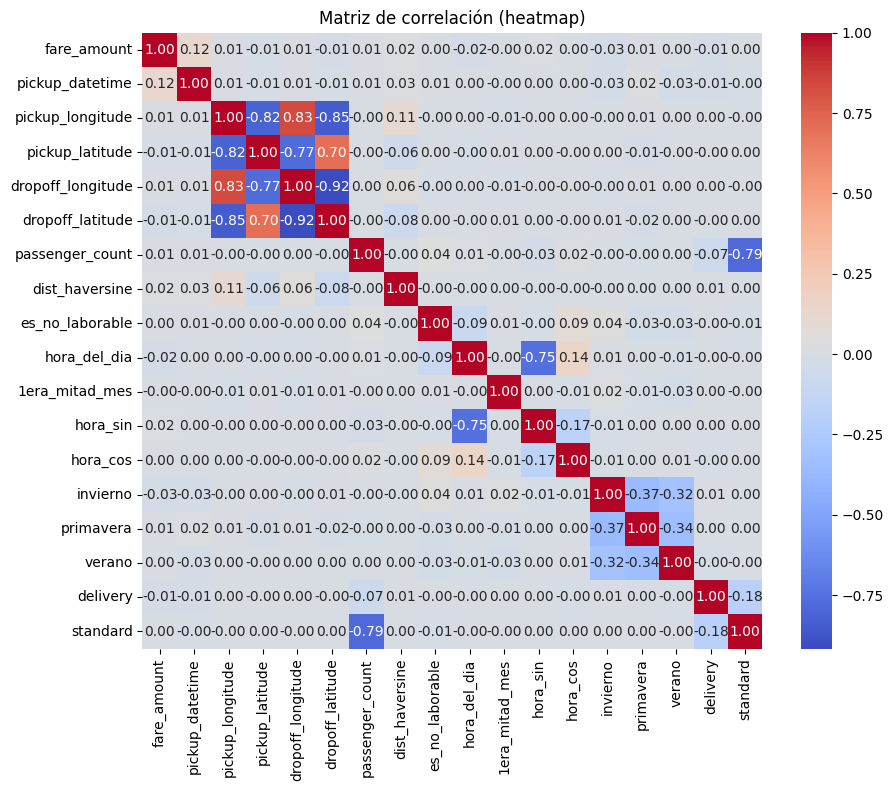

In [22]:
# Calcular la matriz de correlación antes de graficar
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación (heatmap)')
plt.show()

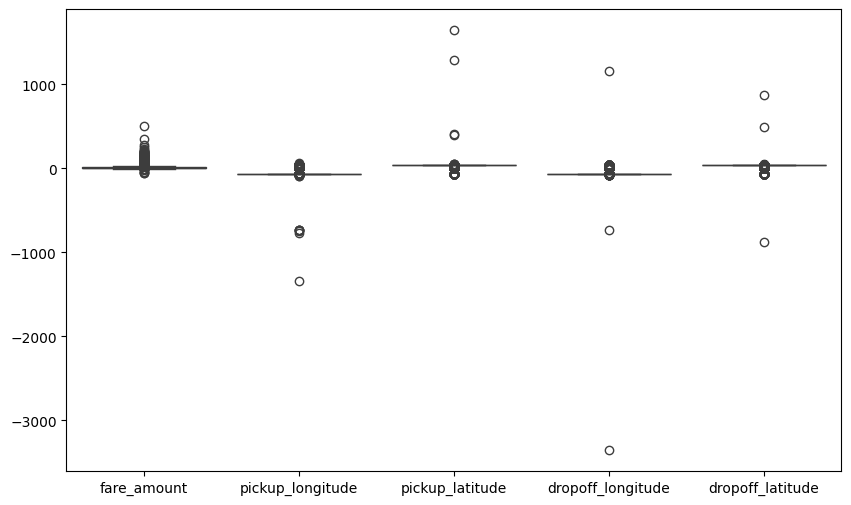

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=df[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']])
plt.show()

In [24]:
# División en train y test (80% - 20%)
y = df["fare_amount"]
X = df.drop(columns=["fare_amount"])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [25]:
# Valores fuera de rango en longitudes
longitudes_fuera_rango = df_train[
    (df_train['pickup_longitude'] < -180) | (df_train['pickup_longitude'] > 180) |
    (df_train['dropoff_longitude'] < -180) | (df_train['dropoff_longitude'] > 180)
]

# Valores fuera de rango en latitudes
latitudes_fuera_rango = df_train[
    (df_train['pickup_latitude'] < -90) | (df_train['pickup_latitude'] > 90) |
    (df_train['dropoff_latitude'] < -90) | (df_train['dropoff_latitude'] > 90)
]

print("Longitudes fuera de rango:")
print(longitudes_fuera_rango[['pickup_longitude', 'dropoff_longitude']])

print("\nLatitudes fuera de rango:")
print(latitudes_fuera_rango[['pickup_latitude', 'dropoff_latitude']])

Longitudes fuera de rango:
        pickup_longitude  dropoff_longitude
103745       -736.216667         -73.982377
91422          57.418457        1153.572603
199936       -736.400000         -73.982215
4949         -748.016667         -74.003570
161652       -735.433332         -74.006373
75851       -1340.648410       -3356.666300
48506        -735.200000         -73.980187

Latitudes fuera de rango:
       pickup_latitude  dropoff_latitude
61793       401.066667         40.754117
91422      1292.016128       -881.985513
56617       404.433332         40.769037
75851      1644.421482        872.697628


In [26]:
# Son errores de carga o registro, no representan ubicaciones reales y son ínfimos, por lo que se procede a eliminarlos
df_train = df_train[
    (df_train['pickup_longitude'] >= -180) & (df_train['pickup_longitude'] <= 180) &
    (df_train['dropoff_longitude'] >= -180) & (df_train['dropoff_longitude'] <= 180) &
    (df_train['pickup_latitude'] >= -90) & (df_train['pickup_latitude'] <= 90) &
    (df_train['dropoff_latitude'] >= -90) & (df_train['dropoff_latitude'] <= 90)
]

In [27]:
# Ver y contar registros donde pickup_longitude y pickup_latitude son iguales a dropoff_longitude y dropoff_latitude
mask = (df['pickup_longitude'] == df['dropoff_longitude']) & (df['pickup_latitude'] == df['dropoff_latitude'])
registros_iguales = df[mask]
print(f"Cantidad de registros con misma lat/lon de origen y destino: {registros_iguales.shape[0]}")
registros_iguales

Cantidad de registros con misma lat/lon de origen y destino: 5632


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_haversine,es_no_laborable,hora_del_dia,1era_mitad_mes,hora_sin,hora_cos,invierno,primavera,verano,delivery,standard
5,4.9,2011-02-12 02:27:09,-73.969019,40.755910,-73.969019,40.755910,1,0.0,1,2,1,0.500000,8.660254e-01,1,0,0,0,1
7,2.5,2012-12-11 13:52:00,0.000000,0.000000,0.000000,0.000000,1,0.0,0,13,1,-0.258819,-9.659258e-01,0,0,0,0,1
11,8.5,2011-05-23 22:15:00,0.000000,0.000000,0.000000,0.000000,1,0.0,0,22,0,-0.500000,8.660254e-01,0,1,0,0,1
48,56.8,2013-01-03 22:24:41,-73.993498,40.764686,-73.993498,40.764686,1,0.0,0,22,1,-0.500000,8.660254e-01,1,0,0,0,1
65,6.0,2014-05-05 19:27:00,0.000000,0.000000,0.000000,0.000000,1,0.0,0,19,1,-0.965926,2.588190e-01,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199880,6.5,2014-02-22 06:45:46,0.000000,0.000000,0.000000,0.000000,1,0.0,1,6,0,1.000000,6.123234e-17,1,0,0,0,1
199883,12.5,2012-09-10 17:39:00,0.000000,0.000000,0.000000,0.000000,2,0.0,0,17,1,-0.965926,-2.588190e-01,0,0,1,0,1
199917,4.5,2013-06-24 22:17:43,-73.793768,40.656939,-73.793768,40.656939,1,0.0,0,22,0,-0.500000,8.660254e-01,0,0,1,0,1
199932,24.9,2011-03-22 13:59:00,-73.974618,40.756295,-73.974618,40.756295,5,0.0,0,13,0,-0.258819,-9.659258e-01,0,1,0,0,0


In [28]:
# Eliminar filas donde passenger_count sea mayor a 6, ya que no son representativas y pueden distorsionar el análisis
df_train = df_train[df_train['passenger_count'] <= 6]

In [29]:
# PARA ENCONTRAR VALORES NEGATIVOS QUE NO CORRESPONDEN Y MINIMOS ABSURDOS
df_train['fare_amount'].value_counts().sort_index().head(20)

fare_amount
-52.00       2
-50.50       1
-49.57       1
-23.70       1
-10.90       1
-7.30        1
-5.00        1
-3.50        3
-3.30        1
-3.00        2
 0.00        5
 0.01        2
 2.50      662
 2.60        1
 2.90      391
 3.00      287
 3.25        1
 3.30     1102
 3.40        9
 3.50      874
Name: count, dtype: int64

Eliminamos los siguientes datos considerados erroneos:
- Fare 0
- Fare 0.01 y 0.11 tambien eliminar ya que no se corresponden a la distancia recorrida
- Todos los fare negativos tambien se eliminan

In [30]:
# Eliminar filas donde fare_amount sea menor o igual a 0.11
df_train = df_train[df_train['fare_amount'] > 0.11]

In [31]:
# Cambiar todos los valores de dist_haversine menores a 0.1 por NaN en df_train
df_train.loc[df_train['dist_haversine'] < 0.1, 'dist_haversine'] = np.nan

In [32]:
# Imputación de dist_haversine en df_train usando regresión lineal
# Filtrar filas con dist_haversine y fare_amount válidos en df_train
dftrain_valid = df_train[~df_train['dist_haversine'].isna()]

# Entrenar modelo de regresión lineal: dist_haversine ~ fare_amount
X = dftrain_valid[['fare_amount']]  # fare_amount como predictor
y = dftrain_valid['dist_haversine'] # dist_haversine como target

model = LinearRegression()
model.fit(X, y)

# Predecir dist_haversine para los viajes con dist_haversine NaN y fare_amount válido
mask_missing = df_train['dist_haversine'].isna()
df_train.loc[mask_missing, 'dist_haversine'] = model.predict(df_train.loc[mask_missing, ['fare_amount']])
df_train.loc[mask_missing, 'dist_haversine'] = df_train.loc[mask_missing, 'dist_haversine'].clip(lower=0)

print(f"Cantidad de valores imputados en df_train: {mask_missing.sum()}")
print(f"Coeficientes del modelo: intercept={model.intercept_:.4f}, coef={model.coef_[0]:.4f}")
print(f"R² del modelo de imputación: {model.score(X, y):.4f}")

Cantidad de valores imputados en df_train: 5397
Coeficientes del modelo: intercept=9.0852, coef=1.0455
R² del modelo de imputación: 0.0007


In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159968 entries, 153248 to 121958
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   fare_amount        159968 non-null  float64       
 1   pickup_datetime    159968 non-null  datetime64[ns]
 2   pickup_longitude   159968 non-null  float64       
 3   pickup_latitude    159968 non-null  float64       
 4   dropoff_longitude  159968 non-null  float64       
 5   dropoff_latitude   159968 non-null  float64       
 6   passenger_count    159968 non-null  int64         
 7   dist_haversine     159968 non-null  float64       
 8   es_no_laborable    159968 non-null  int64         
 9   hora_del_dia       159968 non-null  int32         
 10  1era_mitad_mes     159968 non-null  int64         
 11  hora_sin           159968 non-null  float64       
 12  hora_cos           159968 non-null  float64       
 13  invierno           159968 non-null  int64   

In [34]:
# Mostrar dist_haversine ordenadas de menor a mayor
df_train[['dist_haversine']].sort_values(['dist_haversine']).reset_index(drop=True)

,dist_haversine
0,0.100321
1,0.100431
2,0.100478
3,0.100532
4,0.100975
...,...
159963,8680.851746
159964,8680.863938
159965,8708.233063
159966,8776.106279


In [35]:
# Eliminar columnas que no aportan al análisis
df_train = df_train.drop(columns=['pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude',
    'passenger_count', 'hora_del_dia', 'pickup_datetime'
])

# Eliminar columnas que no aportan al análisis en test
df_test = df_test.drop(columns=['pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude',
    'passenger_count', 'hora_del_dia', 'pickup_datetime'
])

In [36]:
df_train.sort_values('dist_haversine').head()

,fare_amount,dist_haversine,es_no_laborable,1era_mitad_mes,hora_sin,hora_cos,invierno,primavera,verano,delivery,standard
18548,2.5,0.100321,0,0,-0.707107,7.071068e-01,0,0,0,0,1
15063,16.9,0.100431,0,0,-0.866025,-5.000000e-01,0,1,0,0,1
28037,10.5,0.100478,0,0,1.000000,6.123234e-17,0,1,0,0,1
188817,4.3,0.100532,0,1,-1.000000,-1.836970e-16,1,0,0,0,1
25814,23.3,0.100975,0,0,-0.965926,-2.588190e-01,1,0,0,0,1


In [37]:
# Separar variables predictoras y target en train y test
X_train = df_train.drop(columns=['fare_amount'])
y_train = df_train['fare_amount']

X_test = df_test.drop(columns=['fare_amount'])
y_test = df_test['fare_amount']

In [38]:
X_train.sort_values('dist_haversine').head()

,dist_haversine,es_no_laborable,1era_mitad_mes,hora_sin,hora_cos,invierno,primavera,verano,delivery,standard
18548,0.100321,0,0,-0.707107,7.071068e-01,0,0,0,0,1
15063,0.100431,0,0,-0.866025,-5.000000e-01,0,1,0,0,1
28037,0.100478,0,0,1.000000,6.123234e-17,0,1,0,0,1
188817,0.100532,0,1,-1.000000,-1.836970e-16,1,0,0,0,1
25814,0.100975,0,0,-0.965926,-2.588190e-01,1,0,0,0,1


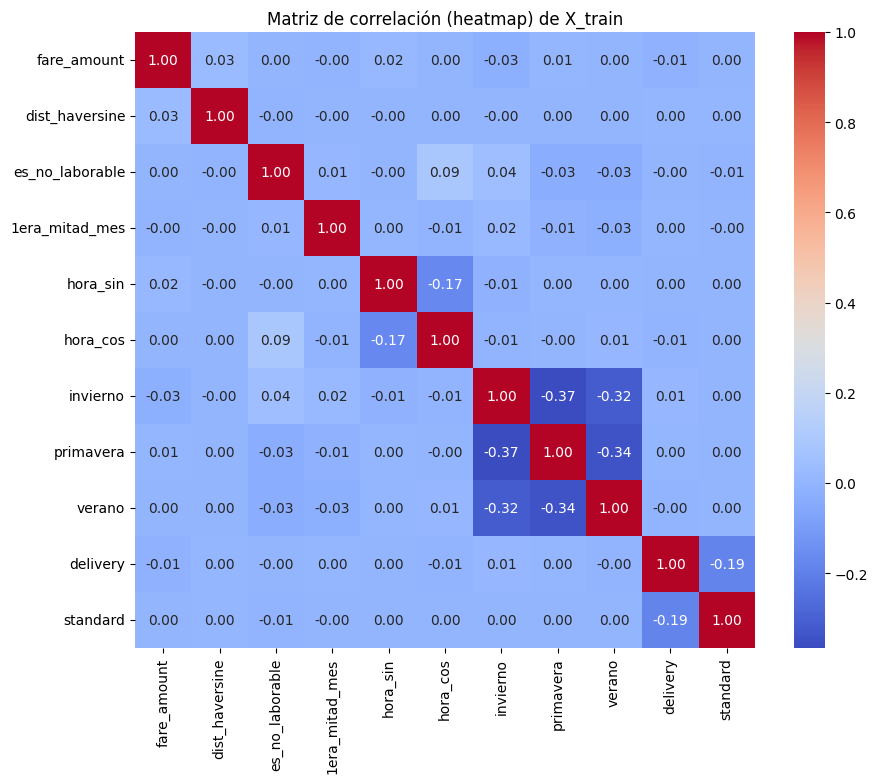

In [39]:
# Heatmap de la matriz de correlación de X_train
corr_matrix = df_train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación (heatmap) de X_train')
plt.show()

ANÁLISIS DE CALIDAD DE DATOS DE ENTRENAMIENTO

Información general:
Shape de X_train: (159968, 10)
Shape de y_train: (159968,)
Columnas en X_train: ['dist_haversine', 'es_no_laborable', '1era_mitad_mes', 'hora_sin', 'hora_cos', 'invierno', 'primavera', 'verano', 'delivery', 'standard']

1. ANÁLISIS DE VALORES FALTANTES
Valores faltantes en X_train:
  dist_haversine: 0 (0.00%)
  es_no_laborable: 0 (0.00%)
  1era_mitad_mes: 0 (0.00%)
  hora_sin: 0 (0.00%)
  hora_cos: 0 (0.00%)
  invierno: 0 (0.00%)
  primavera: 0 (0.00%)
  verano: 0 (0.00%)
  delivery: 0 (0.00%)
  standard: 0 (0.00%)

Valores faltantes en y_train: 0 (0.00%)

2. ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES PREDICTORAS
       dist_haversine  es_no_laborable  1era_mitad_mes       hora_sin  \
count   159968.000000    159968.000000   159968.000000  159968.000000   
mean        20.955915         0.310437        0.461536      -0.194381   
std        376.206906         0.462674        0.498520       0.668672   
min          0.100321  

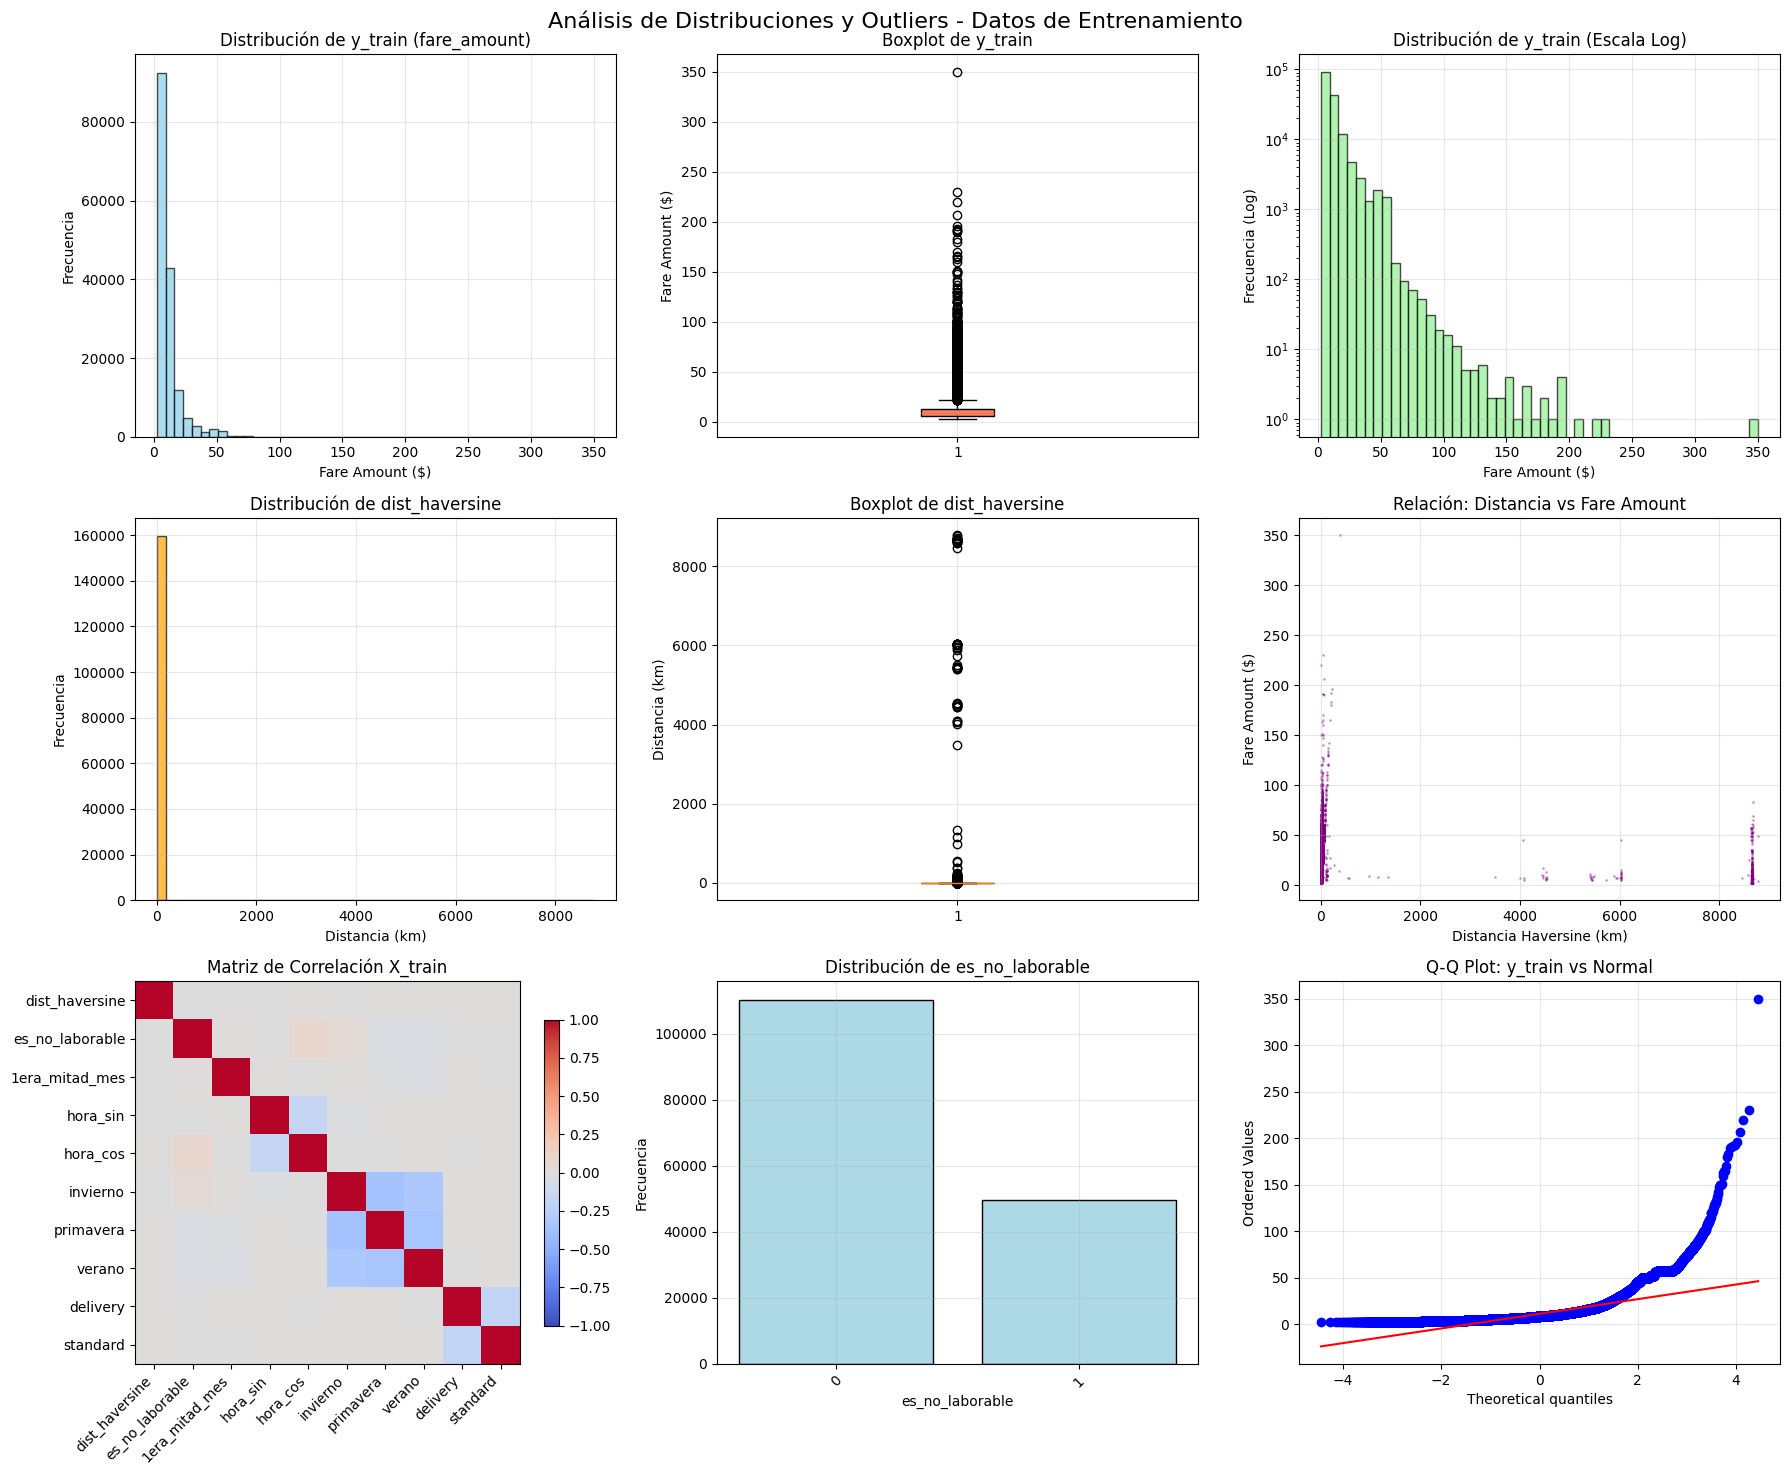


4. DETECCIÓN DE OUTLIERS (Método IQR)

dist_haversine:
  Outliers: 16457 (10.29%)
  Límites: [-3.16, 8.79]
  Rango actual: [0.10, 8782.90]

es_no_laborable:
  Outliers: 0 (0.00%)
  Límites: [-1.50, 2.50]
  Rango actual: [0.00, 1.00]

1era_mitad_mes:
  Outliers: 0 (0.00%)
  Límites: [-1.50, 2.50]
  Rango actual: [0.00, 1.00]

hora_sin:
  Outliers: 0 (0.00%)
  Límites: [-2.92, 2.55]
  Rango actual: [-1.00, 1.00]

hora_cos:
  Outliers: 0 (0.00%)
  Límites: [-2.83, 2.83]
  Rango actual: [-1.00, 1.00]

invierno:
  Outliers: 0 (0.00%)
  Límites: [-1.50, 2.50]
  Rango actual: [0.00, 1.00]

primavera:
  Outliers: 0 (0.00%)
  Límites: [-1.50, 2.50]
  Rango actual: [0.00, 1.00]

verano:
  Outliers: 36603 (22.88%)
  Límites: [0.00, 0.00]
  Rango actual: [0.00, 1.00]

delivery:
  Outliers: 579 (0.36%)
  Límites: [0.00, 0.00]
  Rango actual: [0.00, 1.00]

standard:
  Outliers: 15224 (9.52%)
  Límites: [1.00, 1.00]
  Rango actual: [0.00, 1.00]

5. ANÁLISIS DE ASIMETRÍA (SKEWNESS)
dist_haversine: 22

In [40]:
# Análisis exhaustivo de los datos de entrenamiento (X_train e y_train)
print("="*80)
print("ANÁLISIS DE CALIDAD DE DATOS DE ENTRENAMIENTO")
print("="*80)

print(f"\nInformación general:")
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Columnas en X_train: {list(X_train.columns)}")

# 1. ANÁLISIS DE VALORES FALTANTES
print(f"\n" + "="*60)
print("1. ANÁLISIS DE VALORES FALTANTES")
print("="*60)
missing_X = X_train.isnull().sum()
print("Valores faltantes en X_train:")
for col in X_train.columns:
    missing_count = missing_X[col]
    missing_pct = (missing_count / len(X_train)) * 100
    print(f"  {col}: {missing_count} ({missing_pct:.2f}%)")

missing_y = y_train.isnull().sum()
print(f"\nValores faltantes en y_train: {missing_y} ({(missing_y/len(y_train)*100):.2f}%)")

# 2. ANÁLISIS ESTADÍSTICO DE CADA VARIABLE
print(f"\n" + "="*60)
print("2. ESTADÍSTICAS DESCRIPTIVAS DE VARIABLES PREDICTORAS")
print("="*60)
print(X_train.describe())

print(f"\n" + "="*60)
print("3. ESTADÍSTICAS DESCRIPTIVAS DE VARIABLE OBJETIVO")
print("="*60)
print(y_train.describe())

# 3. VISUALIZACIONES PARA DETECTAR OUTLIERS Y DISTRIBUCIONES
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Análisis de Distribuciones y Outliers - Datos de Entrenamiento', fontsize=16, y=0.98)

# 3.1 Distribución de y_train
axes[0, 0].hist(y_train, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribución de y_train (fare_amount)')
axes[0, 0].set_xlabel('Fare Amount ($)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# 3.2 Boxplot de y_train
box = axes[0, 1].boxplot(y_train, patch_artist=True)
box['boxes'][0].set_facecolor('lightcoral')
axes[0, 1].set_title('Boxplot de y_train')
axes[0, 1].set_ylabel('Fare Amount ($)')
axes[0, 1].grid(True, alpha=0.3)

# 3.3 y_train en escala log
axes[0, 2].hist(y_train, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 2].set_yscale('log')
axes[0, 2].set_title('Distribución de y_train (Escala Log)')
axes[0, 2].set_xlabel('Fare Amount ($)')
axes[0, 2].set_ylabel('Frecuencia (Log)')
axes[0, 2].grid(True, alpha=0.3)

# 3.4 Distribución de dist_haversine (si existe)
if 'dist_haversine' in X_train.columns:
    axes[1, 0].hist(X_train['dist_haversine'], bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].set_title('Distribución de dist_haversine')
    axes[1, 0].set_xlabel('Distancia (km)')
    axes[1, 0].set_ylabel('Frecuencia')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 3.5 Boxplot de dist_haversine
    box_dist = axes[1, 1].boxplot(X_train['dist_haversine'], patch_artist=True)
    box_dist['boxes'][0].set_facecolor('wheat')
    axes[1, 1].set_title('Boxplot de dist_haversine')
    axes[1, 1].set_ylabel('Distancia (km)')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 3.6 Scatter plot: dist_haversine vs y_train
    axes[1, 2].scatter(X_train['dist_haversine'], y_train, alpha=0.3, s=1, color='purple')
    axes[1, 2].set_title('Relación: Distancia vs Fare Amount')
    axes[1, 2].set_xlabel('Distancia Haversine (km)')
    axes[1, 2].set_ylabel('Fare Amount ($)')
    axes[1, 2].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'dist_haversine\nno disponible', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 1].text(0.5, 0.5, 'dist_haversine\nno disponible', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 2].text(0.5, 0.5, 'dist_haversine\nno disponible', ha='center', va='center', transform=axes[1, 2].transAxes)

# 3.7 Matriz de correlación (solo variables numéricas)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    corr_matrix = X_train[numeric_cols].corr()
    im = axes[2, 0].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[2, 0].set_title('Matriz de Correlación X_train')
    axes[2, 0].set_xticks(range(len(numeric_cols)))
    axes[2, 0].set_yticks(range(len(numeric_cols)))
    axes[2, 0].set_xticklabels(numeric_cols, rotation=45, ha='right')
    axes[2, 0].set_yticklabels(numeric_cols)
    plt.colorbar(im, ax=axes[2, 0], shrink=0.8)
else:
    axes[2, 0].text(0.5, 0.5, 'Insuficientes\nvariables numéricas', ha='center', va='center', transform=axes[2, 0].transAxes)

# 3.8 Distribución de variables categóricas (si las hay)
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns
binary_cols = [col for col in X_train.columns if X_train[col].nunique() == 2 and col not in categorical_cols]

if len(categorical_cols) > 0 or len(binary_cols) > 0:
    all_cat_cols = list(categorical_cols) + binary_cols[:3]  # Máximo 3 para visualización
    col_to_plot = all_cat_cols[0] if all_cat_cols else None
    
    if col_to_plot:
        value_counts = X_train[col_to_plot].value_counts()
        axes[2, 1].bar(range(len(value_counts)), value_counts.values, color='lightblue', edgecolor='black')
        axes[2, 1].set_title(f'Distribución de {col_to_plot}')
        axes[2, 1].set_xlabel(col_to_plot)
        axes[2, 1].set_ylabel('Frecuencia')
        axes[2, 1].set_xticks(range(len(value_counts)))
        axes[2, 1].set_xticklabels(value_counts.index, rotation=45)
        axes[2, 1].grid(True, alpha=0.3)
    else:
        axes[2, 1].text(0.5, 0.5, 'No hay variables\ncategóricas', ha='center', va='center', transform=axes[2, 1].transAxes)
else:
    axes[2, 1].text(0.5, 0.5, 'No hay variables\ncategóricas', ha='center', va='center', transform=axes[2, 1].transAxes)

# 3.9 Q-Q plot para normalidad de y_train
from scipy import stats
stats.probplot(y_train, dist="norm", plot=axes[2, 2])
axes[2, 2].set_title('Q-Q Plot: y_train vs Normal')
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. DETECCIÓN DE OUTLIERS EN VARIABLES NUMÉRICAS
print(f"\n" + "="*60)
print("4. DETECCIÓN DE OUTLIERS (Método IQR)")
print("="*60)

outlier_summary = {}
for col in numeric_cols:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = X_train[(X_train[col] < lower_bound) | (X_train[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_pct = (outlier_count / len(X_train)) * 100
    
    outlier_summary[col] = {
        'count': outlier_count,
        'percentage': outlier_pct,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
    
    print(f"\n{col}:")
    print(f"  Outliers: {outlier_count} ({outlier_pct:.2f}%)")
    print(f"  Límites: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"  Rango actual: [{X_train[col].min():.2f}, {X_train[col].max():.2f}]")

# 5. ANÁLISIS DE ASIMETRÍA
print(f"\n" + "="*60)
print("5. ANÁLISIS DE ASIMETRÍA (SKEWNESS)")
print("="*60)
for col in numeric_cols:
    skew = X_train[col].skew()
    print(f"{col}: {skew:.3f}", end="")
    if abs(skew) < 0.5:
        print(" (Distribución aproximadamente simétrica)")
    elif abs(skew) < 1:
        print(" (Moderadamente asimétrica)")
    else:
        print(" (Muy asimétrica)")

print(f"\ny_train skewness: {y_train.skew():.3f}")

# 6. ANÁLISIS DE VALORES EXTREMOS
print(f"\n" + "="*60)
print("6. VALORES EXTREMOS EN VARIABLES CLAVE")
print("="*60)

print("Y_TRAIN (fare_amount):")
print("  Valores más altos:")
y_train_sorted = y_train.sort_values(ascending=False)
for i in range(min(5, len(y_train_sorted))):
    print(f"    {i+1}. ${y_train_sorted.iloc[i]:.2f}")

print("  Valores más bajos:")
y_train_sorted_low = y_train.sort_values(ascending=True)
for i in range(min(5, len(y_train_sorted_low))):
    print(f"    {i+1}. ${y_train_sorted_low.iloc[i]:.2f}")

if 'dist_haversine' in X_train.columns:
    print(f"\nDIST_HAVERSINE:")
    print("  Distancias más largas:")
    dist_sorted = X_train['dist_haversine'].sort_values(ascending=False)
    for i in range(min(5, len(dist_sorted))):
        print(f"    {i+1}. {dist_sorted.iloc[i]:.2f} km")
    
    print("  Distancias más cortas:")
    dist_sorted_low = X_train['dist_haversine'].sort_values(ascending=True)
    for i in range(min(5, len(dist_sorted_low))):
        print(f"    {i+1}. {dist_sorted_low.iloc[i]:.6f} km")

# 7. RECOMENDACIONES PARA PREPROCESSING
print(f"\n" + "="*60)
print("7. RECOMENDACIONES PARA PREPROCESSING")
print("="*60)

recommendations = []

# Revisar valores faltantes
total_missing = X_train.isnull().sum().sum() + y_train.isnull().sum()
if total_missing > 0:
    recommendations.append("Hay valores faltantes que requieren imputación")

# Revisar outliers
high_outlier_cols = [col for col, info in outlier_summary.items() if info['percentage'] > 5]
if high_outlier_cols:
    recommendations.append(f"Variables con muchos outliers (>5%): {high_outlier_cols}")

# Revisar asimetría
highly_skewed = [col for col in numeric_cols if abs(X_train[col].skew()) > 1]
if highly_skewed:
    recommendations.append(f"Variables muy asimétricas (requieren transformación): {highly_skewed}")

# Revisar variable objetivo
if abs(y_train.skew()) > 1:
    recommendations.append("Variable objetivo muy asimétrica - considerar transformación log")

# Revisar escalas
ranges = {col: X_train[col].max() - X_train[col].min() for col in numeric_cols}
if len(ranges) > 1:
    max_range = max(ranges.values())
    min_range = min(ranges.values())
    if max_range / min_range > 100:
        recommendations.append("Variables en escalas muy diferentes - requiere normalización")

if not recommendations:
    recommendations.append("Los datos parecen estar en buenas condiciones para el modelado")

for rec in recommendations:
    print(f"  {rec}")

print(f"\n" + "="*60)
print("RESUMEN FINAL")
print("="*60)
print(f"✓ Registros de entrenamiento: {len(X_train):,}")
print(f"✓ Variables predictoras: {X_train.shape[1]}")
print(f"✓ Variables numéricas: {len(numeric_cols)}")
print(f"✓ Variables categóricas/binarias: {X_train.shape[1] - len(numeric_cols)}")
print(f"✓ Valores faltantes totales: {total_missing:,}")
print(f"✓ Datos listos para modelado: {'Sí' if total_missing == 0 else 'No (requiere limpieza)'}")

In [ ]:
# Quizas sea necesario la Transformación logarítmica (corrige asimetría) que cambia la forma de la distribución, corrige la asimetría y reduce el impacto de outliers
#df['dist_haversine'] = np.log1p(df['dist_haversine'])
#df['fare_amount'] = np.log1p(df['fare_amount'])

In [ ]:
# Escalar x (features)
scaler = StandardScaler()
X_train['dist_haversine'] = scaler.fit_transform(X_train[['dist_haversine']])
X_test['dist_haversine'] = scaler.transform(X_test[['dist_haversine']])

# Escalar y (target)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Modelo Regresión lineal
modelo = LinearRegression()
modelo.fit(X_train, y_train_scaled)
y_pred = modelo.predict(X_test)

# Evaluación simple del modelo
print("\nModelo con dist_haversine")
print("MSE:", mean_squared_error(y_test_scaled, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_scaled, y_pred)))
print("MAE:", mean_absolute_error(y_test_scaled, y_pred))
print("MAPE:", np.mean(np.abs((y_test_scaled - y_pred) / y_test_scaled)) * 100)
print("R2:", r2_score(y_test_scaled, y_pred))

Modelo con distancia_recorrida_km
MSE: 1.107951093690339
RMSE: 1.0525925582533533
MAE: 0.623143246866503
MAPE: 105.31335351970131
R2: 0.0010259616709088482

Modelo con dist_haversine
MSE: 1.1072589067541665
RMSE: 1.0522637058998883
MAE: 0.6229491905431669
MAPE: 105.29435304343974
R2: 0.001650065733664552


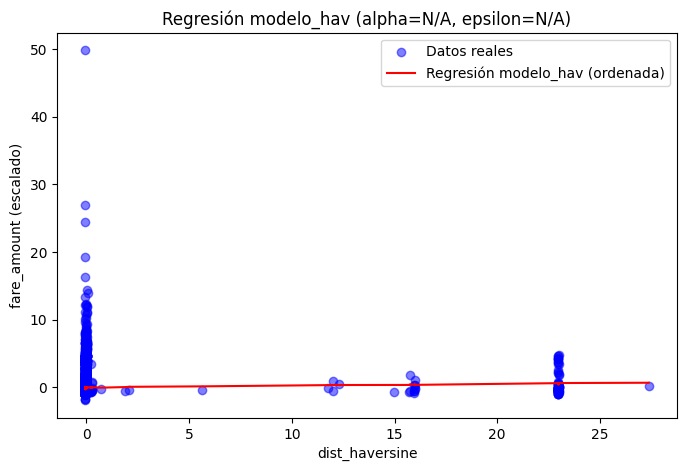

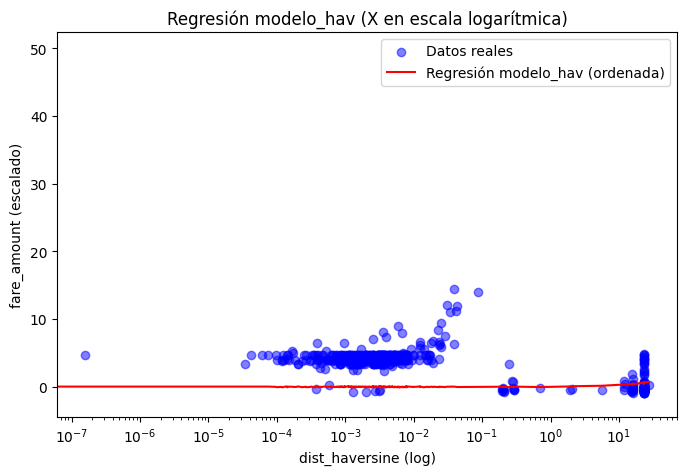

In [ ]:
# Predecir con el modelo modelo_hav
y_pred = modelo.predict(X_test)

# Ordenar X_test.iloc[:, 0] y y_pred para la línea de regresión
x_vals = X_test.iloc[:, 0].values
sort_idx = np.argsort(x_vals)
x_sorted = x_vals[sort_idx]
y_pred_sorted = y_pred[sort_idx]

plt.figure(figsize=(8,5))
plt.scatter(X_test.iloc[:, 0], y_test_scaled, color='blue', alpha=0.5, label='Datos reales')
plt.plot(x_sorted, y_pred_sorted, color='red', label='Regresión modelo (ordenada)')
plt.xlabel(X_test.columns[0])
plt.ylabel('fare_amount (escalado)')
alpha_val = getattr(modelo, 'alpha', 'N/A')
epsilon_val = getattr(modelo, 'epsilon', 'N/A')
plt.title(f'Regresión modelo (alpha={alpha_val}, epsilon={epsilon_val})')
plt.legend()
plt.show()

# Visualización en escala logarítmica para X si hay mucha dispersión
plt.figure(figsize=(8,5))
plt.scatter(X_test.iloc[:, 0], y_test_scaled, color='blue', alpha=0.5, label='Datos reales')
plt.plot(x_sorted, y_pred_sorted, color='red', label='Regresión modelo (ordenada)')
plt.xlabel(X_test.columns[0] + ' (log)')
plt.ylabel('fare_amount (escalado)')
plt.xscale('log')
plt.title(f'Regresión modelo (X en escala logarítmica)')
plt.legend()
plt.show()

In [391]:
pd.DataFrame(y_train_scaled).describe()

,0
count,1.599680e+05
mean,-6.182958e-17
std,1.000003e+00
min,-9.043582e-01
25%,-5.468864e-01
50%,-2.915495e-01
75%,1.169896e-01
max,3.458748e+01


In [200]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

In [ ]:
# Evolución de los coeficientes de Ridge en función de alpha usando X_hav_train y y_train
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

alphas = np.logspace(-4, 2, 100)
coefs = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    modelo_aux.fit(X_hav_train, y_train)
    coefs.append(modelo_aux.steps[1][1].coef_.flatten())

coefs = np.array(coefs)

fig, ax = plt.subplots(figsize=(15, 5))
for i, col in enumerate(X_hav_train.columns):
    ax.plot(alphas, coefs[:, i], label=col)
ax.set_xscale('log')
ax.set_xlabel('alpha (escala log)')
ax.set_ylabel('Coeficientes')
ax.set_title('Evolución de los coeficientes de Ridge vs alpha')
plt.axis('tight')
plt.legend()
plt.show()
        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

In [202]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

NOS QUEDAMOS CON HAVERSINE PORQUE AJUSTA MEJOR

In [ ]:
# Ejemplo de reshape para cada conjunto de datos, útil si solo usás una variable predictora (columna)
y_train_rs = y_train.values.reshape(-1, 1)
y_test_rs = y_test.values.reshape(-1, 1)

X_hav_train
X_hav_test

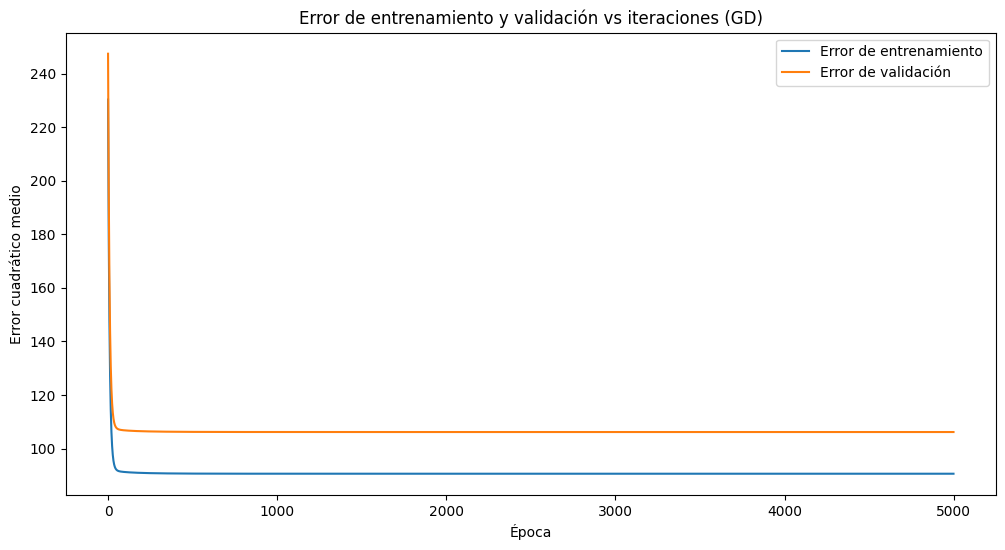

array([[4.55860757],
       [0.24848683],
       [0.03296115],
       [2.2372405 ],
       [2.2958578 ],
       [0.21593897],
       [0.01816075],
       [1.05657299],
       [1.61739716],
       [1.55707974],
       [1.88694716],
       [1.48884065],
       [3.0021088 ],
       [3.12533635]])

In [ ]:
gradient_descent(X_hav_train, y_train_rs, X_hav_test, y_test_rs, lr=0.01, epochs=5000)

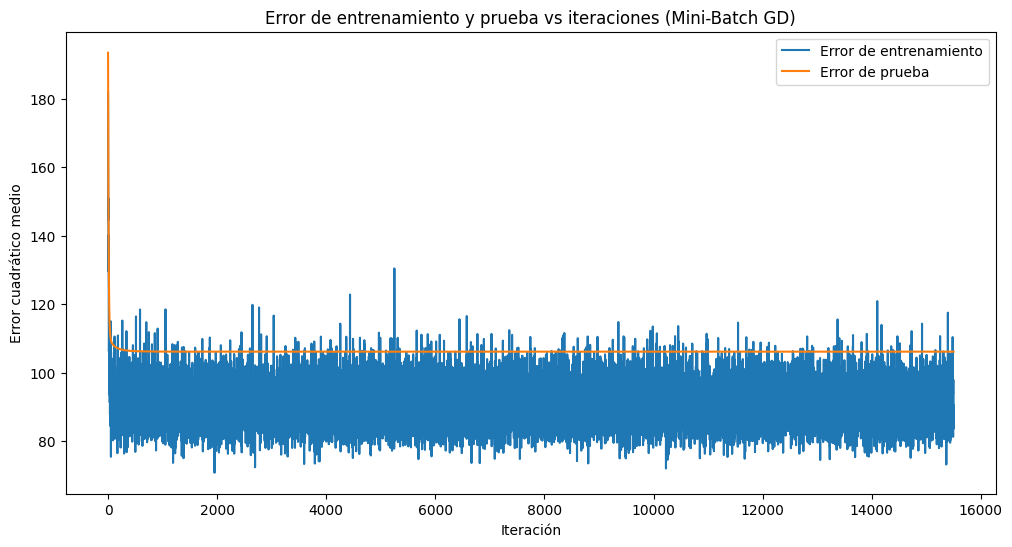

array([[6.1607851 ],
       [0.24612909],
       [0.01742977],
       [2.17757217],
       [2.23774933],
       [0.21815911],
       [0.02084091],
       [0.59095849],
       [2.98722682],
       [3.12756103]])

In [ ]:
mini_batch_gradient_descent(X_hav_train, y_train_rs, X_hav_test, y_test_rs, lr=0.01, epochs=500, batch_size=5000)

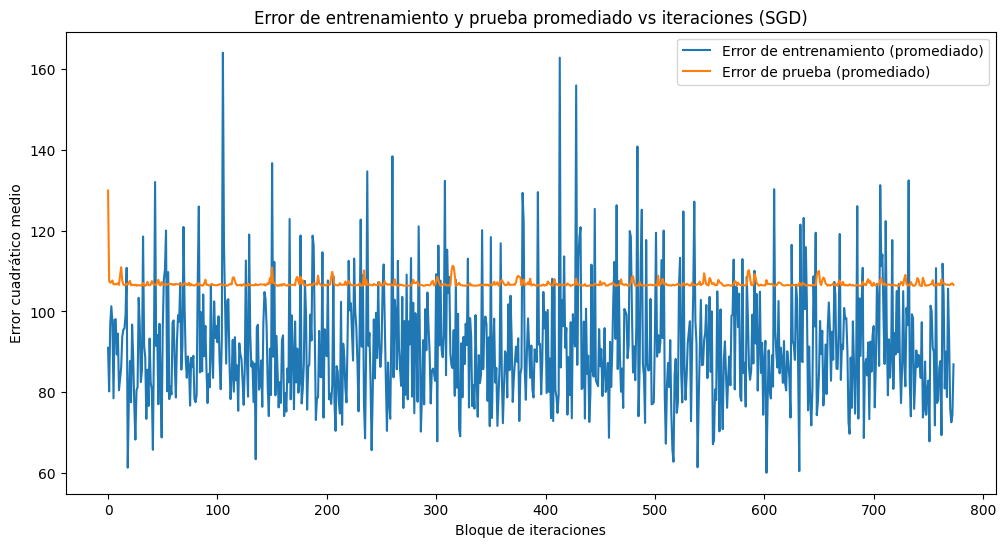

array([[6.03516285],
       [0.95690945],
       [0.11679807],
       [1.95693671],
       [1.51545845],
       [0.14004476],
       [0.24570199],
       [1.63656068],
       [3.68267656],
       [3.64730492]])

In [ ]:

def stochastic_gradient_descent_avg(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, avg_window=1000):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)
            W = W - (lr * gradient)

    # Promediar errores cada avg_window iteraciones
    def moving_average(arr, window):
        arr = np.array(arr).flatten()
        return [np.mean(arr[i:i+window]) for i in range(0, len(arr), window)]

    train_errors_avg = moving_average(train_errors, avg_window)
    test_errors_avg = moving_average(test_errors, avg_window)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors_avg, label='Error de entrenamiento (promediado)')
    plt.plot(test_errors_avg, label='Error de prueba (promediado)')
    plt.xlabel('Bloque de iteraciones')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba promediado vs iteraciones (SGD)')
    plt.show()

    return W

# Usar la función promediada:
stochastic_gradient_descent_avg(X_hav_train, y_train_rs, X_hav_test, y_test_rs, lr=0.0005, epochs=5, avg_window=1000)

c:\Users\FZ\Desktop\TUIA_4TO\AA1\venvAA1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


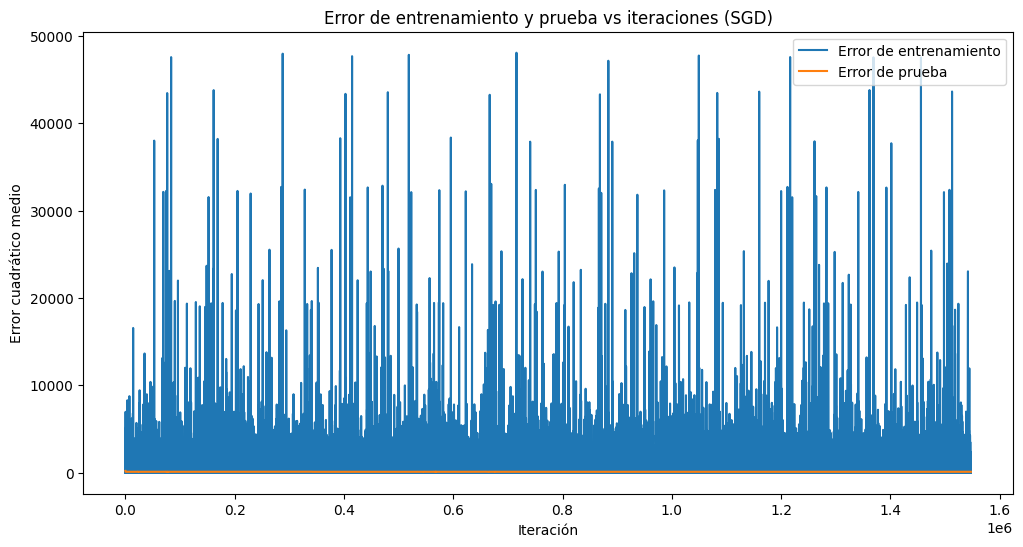

array([[ 5.52226616],
       [-0.31856647],
       [ 0.57684433],
       [ 4.13911715],
       [ 3.70948093],
       [ 0.63031402],
       [ 0.73973179],
       [ 0.0452189 ],
       [ 1.61954083],
       [ 2.09775714]])

In [ ]:
stochastic_gradient_descent(X_hav_train, y_train_rs, X_hav_test, y_test_rs, lr=0.001, epochs=10)

In [ ]:
# Usamos las variables escaladas y todas las features
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

print("Mejor alpha encontrado:", lasso_cv.alpha_)
print("Coeficientes:", lasso_cv.coef_)

# Predicción y evaluación en test
y_pred_lasso = lasso_cv.predict(X_test)
print("\nResultados LassoCV:")
print("MSE:", mean_squared_error(y_test, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("MAE:", mean_absolute_error(y_test, y_pred_lasso))
print("MAPE:", np.mean(np.abs((y_test - y_pred_lasso) / y_test)) * 100)
print("R2:", r2_score(y_test, y_pred_lasso))

In [ ]:
# 6. Visualización de datos
# Comentario: Se grafican histogramas y scatterplots para analizar la distribución y relaciones entre variables.
# - Histograma de cada variable
# - Scatterplots entre variables relevantes
# - Diagramas de caja

In [ ]:
# 11.b. Métodos de gradiente descendente (SGDRegressor, otros)
# Comentario: Se prueban diferentes variantes de gradiente descendente.
# - Se grafican errores vs iteraciones (loss vs epochs)

In [ ]:
# 15. Optimización y comparación de hiperparámetros
# Comentario: Se varían los hiperparámetros y se observa el efecto en el desempeño del modelo.
# - GridSearchCV, RandomizedSearchCV, o análisis manual


In [ ]:
# 16. Comparación de modelos
# Comentario: Se compara el desempeño de los distintos modelos y se selecciona el mejor.
# - Justificación de la métrica de comparación